# Problem Set 6: Solution


## Part 1: Exploring the Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll at the very least need the train.csv data.

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations, and to understand the distribution of each variable (and determine whether the variables should be normalized or not). Are any of the potential predictor variables (i.e., anything execpt for survival) collinear or highly correlated? 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
# enter your code here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import IPython
%matplotlib inline

In [60]:
titanic_data = pd.read_csv('train.csv')
titanic_data_raw = titanic_data.copy()
print(titanic_data.shape)
titanic_data.head(3)


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### missing value

In [61]:
missing = pd.DataFrame({"data_type": titanic_data.dtypes, "null_num": titanic_data.isnull().sum()})
missing

,data_type,null_num
PassengerId,int64,0
Survived,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,177
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,0


In [62]:
# Embarked: fill the missing values with the mode
embarked_mode = titanic_data['Embarked'].mode()[0]
titanic_data['Embarked'].fillna(embarked_mode,inplace=True)

# Sex and Embarked are of string type. We need to convert them into numerical values.
titanic_data['Sex_int'] = 0
titanic_data['Sex_int'][titanic_data.Sex == 'male'] = 1
embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
titanic_data['Embarked_int'] = titanic_data.apply(lambda x: embarked_dict[x['Embarked']], axis=1)

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

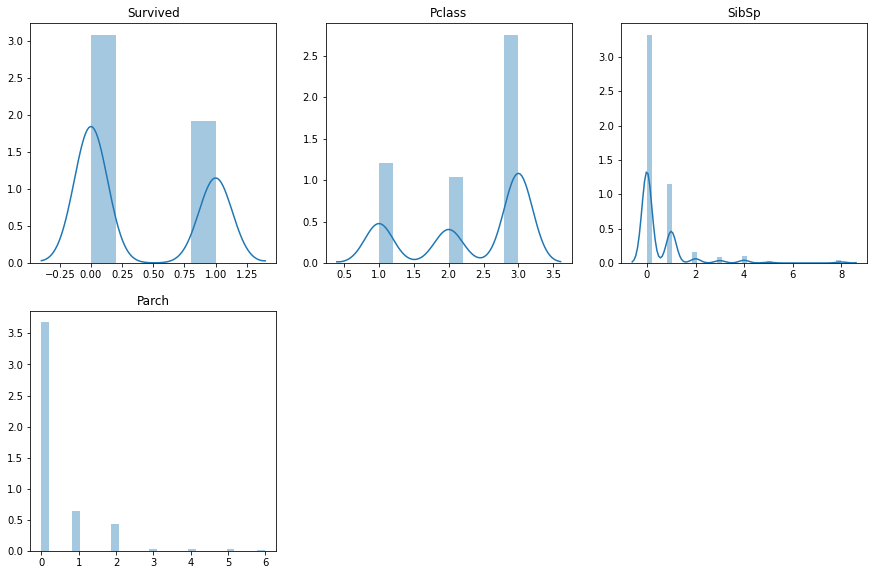

In [63]:
feature_selected = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'Sex_int', 'Embarked_int']
plt.figure(figsize=(15,15))
for i in range(len(feature_selected)):
    feature_this = titanic_data[feature_selected[i]]
    feature_this = feature_this.dropna()
    plt.subplot(3,3,i+1)
    plt.title(feature_selected[i])
    sns.distplot(feature_this)
    plt.xlabel('')

The distribution of Fare is skewed. We need to log transform this variable.

In [64]:
titanic_data['Fare_log'] = np.log(titanic_data['Fare'] + 1)  # +1 because the min is 0.

### exploratory analysis

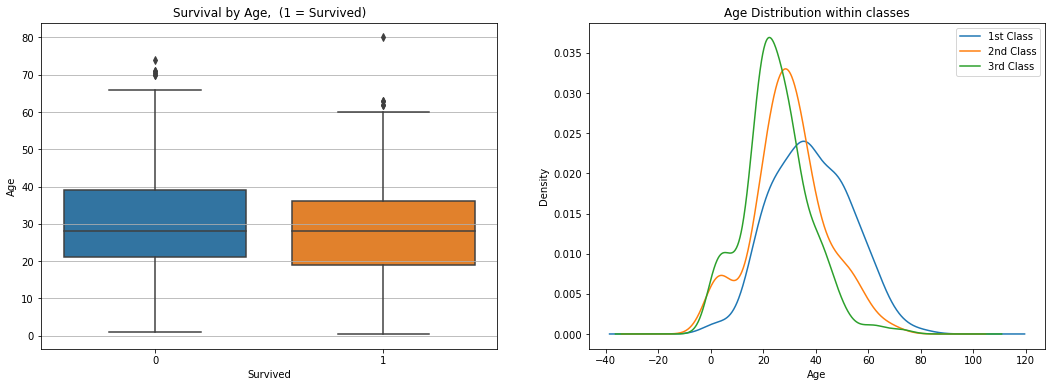

In [65]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6)) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55


plt.subplot(1,2,1)
sns.boxplot(x="Survived", y="Age", data=titanic_data)
plt.ylabel("Age")
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

plt.subplot(1,2,2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
titanic_data.Age[titanic_data.Pclass == 1].plot(kind='kde')    
titanic_data.Age[titanic_data.Pclass == 2].plot(kind='kde')
titanic_data.Age[titanic_data.Pclass == 3].plot(kind='kde')
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

plt.show()

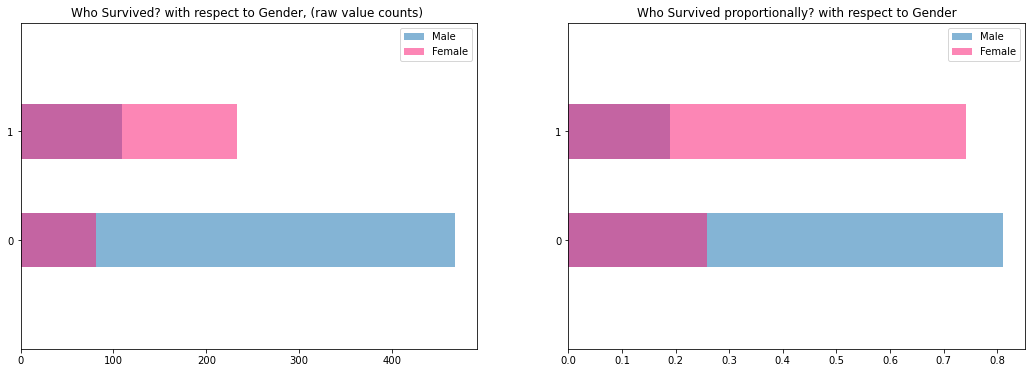

In [66]:
fig = plt.figure(figsize=(18,6))

#create a plot of two subsets, male and female, of the survived variable.
#After we do that we call value_counts() so it can be easily plotted as a bar graph. 
#'barh' is just a horizontal bar graph
titan_train_male = titanic_data.Survived[titanic_data.Sex == 'male'].value_counts().sort_index()
titan_train_female = titanic_data.Survived[titanic_data.Sex == 'female'].value_counts().sort_index()

plt.subplot(1,2,1)
titan_train_male.plot(kind='barh',label='Male', alpha=0.55)
titan_train_female.plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived? with respect to Gender, (raw value counts) "); plt.legend(loc='best')
plt.ylim(-1, 2) 

#adjust graph to display the proportions of survival by gender
plt.subplot(1,2,2)
(titan_train_male/float(titan_train_male.sum())).plot(kind='barh',label='Male', alpha=0.55)  
(titan_train_female/float(titan_train_female.sum())).plot(kind='barh', color='#FA2379',label='Female', alpha=0.55)
plt.title("Who Survived proportionally? with respect to Gender"); plt.legend(loc='best')

plt.ylim(-1, 2)
plt.show()

### correlation

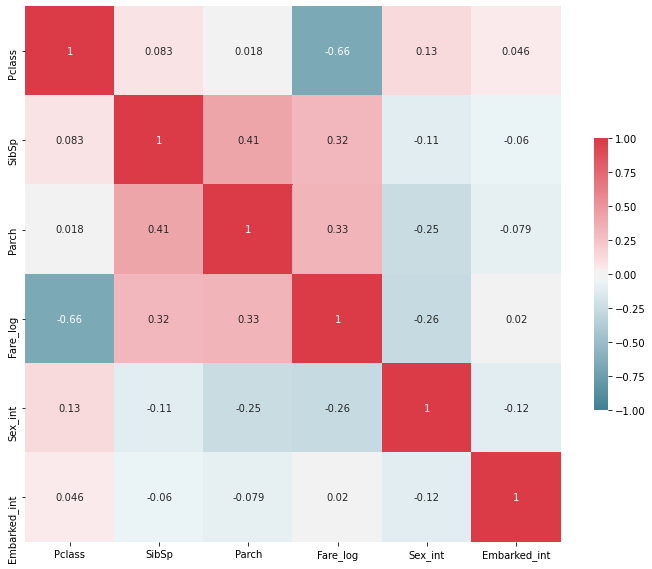

In [67]:
feature_selected = ['Pclass', 'SibSp', 'Parch', 'Fare_log', 'Sex_int', 'Embarked_int']
plt.figure(figsize=(12,10))
corr = titanic_data[feature_selected].corr()
# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, annot=True, cbar_kws={'shrink':.5})

In [68]:
# highest positive correlation
corr_1 = corr[corr!=1].max().sort_values(ascending=False)
two_variable = list(corr_1.index[0:2])
corr_ = corr_1[0]
print('{} and {} have highest correlation positive correlation: {:.2f}'.format(two_variable[0], two_variable[1], corr_))

# highest negative correlation
corr_2 = corr.min().sort_values(ascending=True)
two_variable = list(corr_2.index[0:2])
corr_ = corr_2[0]
print('{} and {} have highest negative correlation: {:.2f}'.format(two_variable[0], two_variable[1], corr_))

Parch and SibSp have highest correlation positive correlation: 0.41
Pclass and Fare_log have highest negative correlation: -0.66


Parch and SibSp are correlated because family groups are likely to have more siblings / spouses and parents / children. Pclass and Fare_log have a negative correlation because tickets with a better class are more expensive.

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. What do you conclude?

I will use two methods to figure out the correlation between factors and survival.
- correlation
- logistic regression

In [69]:
from scipy.stats import pearsonr

r_all = []
p_all = []
for i in feature_selected:
    r, p = pearsonr(titanic_data['Survived'], titanic_data[i])
    r_all.append(r)
    p_all.append(p)
pd.DataFrame({'feature':feature_selected, 'correlation':r_all, 'p':p_all})[['feature', 'correlation', 'p']]

,feature,correlation,p
0,Pclass,-0.338481,2.537047e-25
1,SibSp,-0.035322,2.922439e-01
2,Parch,0.081629,1.479925e-02
3,Fare_log,0.329862,4.646670e-24
4,Sex_int,-0.543351,1.406066e-69
5,Embarked_int,0.106811,1.408312e-03


The above table shows that Pclass, Fare, and Sex have high correlation with survival. A person with a better class ticket or more expensive ticket, and women have a higher probability to survive. Besides, Parch, Age, and Embarked are also correlated with survival.

In [70]:
import statsmodels.formula.api as smf

mod = smf.logit(formula='Survived ~ C(Pclass) + SibSp + Parch + Fare_log + Sex_int + C(Embarked_int)', data=titanic_data)
res = mod.fit()
print(res.summary2())

Optimization terminated successfully.
         Current function value: 0.452387
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.321     
Dependent Variable:   Survived          AIC:               824.1542  
Date:                 2020-04-21 10:13  BIC:               867.2853  
No. Observations:     891               Log-Likelihood:    -403.08   
Df Model:             8                 LL-Null:           -593.33   
Df Residuals:         882               LLR p-value:       2.7667e-77
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             0.7024   0.6955   1.0099 0.3125 -0.6608  2.0656
C(Pclass)[T.2]  

The logistic regression result shows that Pclass, SibSp, Fare, and Sex are significantly related to survival. Similar to the correlation result, a person with a better class ticket or more expensive ticket, and women have a higher probability to survive. Besides, passengers with smaller SibSp are more likely to survive.

The logistic regression shows the *joint* relationship between each factor and survival, conditional on other factors. Different from the unconditional correlation, Embarked and Parch are not significantly correlated with survival in the logistic regression. This might be because Parch and Embarked are correlated with other variables.

### data pre-processing

In [71]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

enc = preprocessing.OneHotEncoder()
titanic_data_onehot = pd.DataFrame(enc.fit_transform(titanic_data[['Embarked_int']]).toarray())
titanic_data_onehot.columns = ['Embarked_S', 'Embarked_C', 'Embarked_Q']
titanic_data_onehot['PassengerId'] = titanic_data['PassengerId']
titanic_data = titanic_data.merge(titanic_data_onehot, on='PassengerId', how='inner')


In [72]:
def normalize(data):
    return (data - np.mean(data)) / np.std(data)

In [73]:
feature_to_normalize= ['SibSp', 'Parch', 'Fare_log']
for i in feature_to_normalize:
    titanic_data[i] = normalize(titanic_data[[i]])

In [74]:
titanic_data_impute = titanic_data.copy()

In [75]:
# Age: use the title of passengers' name to decide the age
def get_title(name):
    # title ends with a dot
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return None


titanic_data_impute['Title'] = titanic_data_impute['Name'].apply(get_title)
titanic_data_impute.groupby('Title').size()

Title
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
dtype: int64

In [76]:
title_age = titanic_data_impute.groupby('Title')['Age'].median().reset_index(name='age_median')
title_age_dict = dict(zip(title_age.Title, title_age.age_median))


def get_median_age(x):
    if np.isnan(x['Age']):
        return title_age_dict[x['Title']]
    else:
        return x['Age']

titanic_data_impute['Age_inferred'] = titanic_data_impute.apply(lambda x: get_median_age(x), axis=1)

In [77]:
feature_selected = ['Survived', 'Pclass', 'SibSp', 'Parch', 'Fare_log', 'Sex_int', 'Embarked_C', 'Embarked_Q']
titanic_data = titanic_data[feature_selected]
titanic_data_train, titanic_data_hold = train_test_split(titanic_data, test_size=0.2)

feature_imput_selected = feature_selected + ['Age_inferred']
titanic_data_impute = titanic_data_impute[feature_imput_selected]
titanic_data_impute_train, titanic_data_impute_hold = train_test_split(titanic_data_impute, test_size=0.2)

## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree](http://scikit-learn.org/stable/modules/tree.html#tree) library in sklearn, fit a model to predict titanic survival. Make sure you come up with an appropriate way of handling each of the input variables before feeding them in to the decision tree. You can use the [DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) method to implement 10-fold cross-validation.

For this any the following problems, you should set aside some of your training data as held-out test data, prior to cross-validation. Report the average training and testing accuracy across your 10 folds, and show a diagram of the tree (at least the first three levels). Finally, select the best-performing decision tree (i.e., the one that achieved the highest cross-validated performance) and report the performance of the fitted model on the held-out test data -- how does it compare to the cross-validated accuracy?


In [78]:
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
import IPython

In [79]:
def get_accuracy(model, data, holds):
    kf = KFold(n_splits=10, shuffle=True)
    features = data.columns
    X = data[list(set(features) - set(['Survived']))].values
    y = data['Survived'].values
    X_hold = holds[list(set(features) - set(['Survived']))].values
    y_hold = holds['Survived'].values

    train_score_all = []
    test_score_all = []
    models = []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        train_score_all.append(model.score(X_train, y_train))
        test_score_all.append(model.score(X_test, y_test))
        models.append(model)
    best_model = models[np.argmax(test_score_all)]
    train_avg = np.mean(train_score_all)
    test_avg = np.mean(test_score_all)
    hold_avg = best_model.score(X_hold, y_hold)
    print('average training accuracy: {:.2f}'.format(train_avg))
    print('average testing accuracy: {:.2f}'.format(test_avg))
    print('hold-out accuracy: {:.2f}'.format(hold_avg))
    return [train_avg, test_avg, hold_avg], best_model

In [80]:
model = tree.DecisionTreeClassifier(criterion='entropy')
acc, best_model = get_accuracy(model, titanic_data_train, titanic_data_hold)
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)

average training accuracy: 0.93
average testing accuracy: 0.79
hold-out accuracy: 0.80
average training accuracy: 0.98
average testing accuracy: 0.76
hold-out accuracy: 0.81


The accuracy of the hold-out test data is slightly higher than the cross-validated accuracy, which is not surprising because the one that achieved the highest cross-validated performance might be caused by the fact that the training set has lots of similar cases to the test set for that cv. For different splits, it is also possible that the hold-out accuracy is lower than the average cross-validated accuracy.

In [81]:
import graphviz 
dot_data = tree.export_graphviz(best_model, out_file=None,
                                class_names=['not survived','survived'], 
                                feature_names=list(set(feature_selected) - set(['Survived'])),
                                special_characters=True, max_depth=3)
graph = graphviz.Source(dot_data)
graph

ValueError: Length of feature_names, 7 does not match number of features, 8

From the tree above, the first level shows that if a passenger is female, then she will most likely survive, which correponds with the conclusion of 1.2. Besides, Parch and fare are close to the root. They have significant effects on survival.

### 2.2 Tree tuning

Use all of the data (minus the held-out data) to re-fit a single decision tree with max_depth = 4 (i.e., no cross-validation). Show the tree diagram and also plot the feature importances. What do you observe?

In [85]:
model_single_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
features = titanic_data_train.columns
X = titanic_data_train[list(set(features) - set(['Survived']))].values
y = titanic_data_train['Survived'].values
model_single_tree.fit(X,y)
dot_data = tree.export_graphviz(model_single_tree, out_file=None,
                                class_names=['not survived','survived'], 
                                feature_names=list(set(features) - set(['Survived'])),
                                special_characters=True, max_depth=4)
graph = graphviz.Source(dot_data) 
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

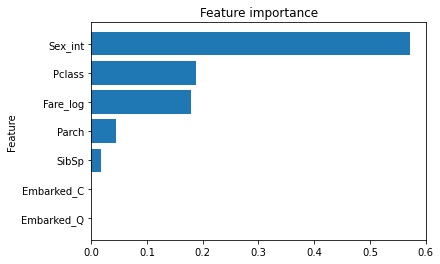

In [86]:
features = list(set(features) - set(['Survived']))
importances = model_single_tree.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()

When we limit the tree to a depth of 4, sex is the most important feature, followed by class, fare, and parch.

### 2.3 Sensitivity analysis
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how max_depth affects train and test accuracy. On a single axis, plot train and test accuracy as a function of max_depth. Use a red line to show test accuracy and a blue line to show train accuracy. Do not use your held-out test data.

Second, show how test accuracy relates to both max_depth and min_samples_leaf. Specifically, create a 3-D plot where the x-axis is max_depth, the y-axis is min_samples_leaf, and the z-axis shows accuracy. What combination of max_depth and min-samples_leaf achieves the highest accuracy? How sensitive are the results to these two parameters?

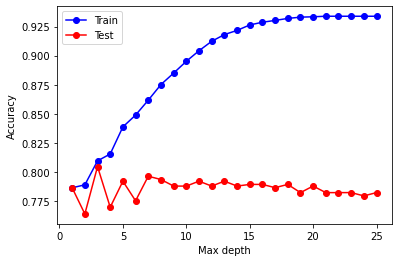

In [103]:
from sklearn.model_selection import cross_validate
result_train = []
result_test = []
max_depth = range(1,26)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

We didn't notice the convex pattern for the accuray in the testing set, implying that the model doesn't have a serious overfitting issue.

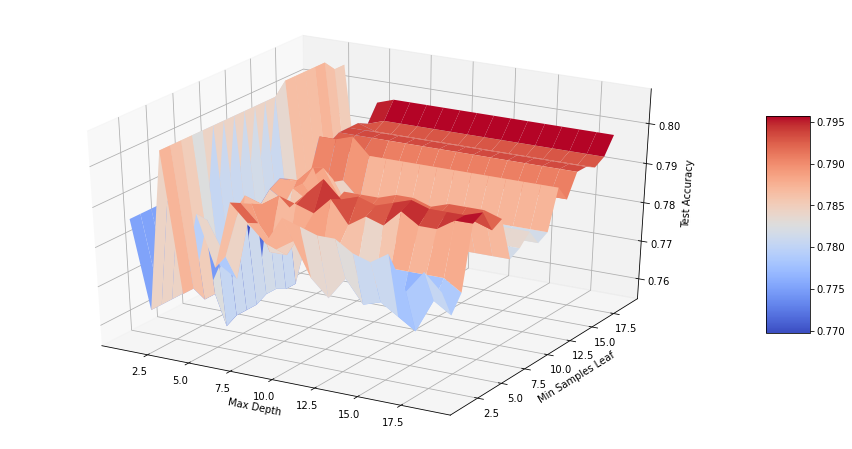

In [90]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

max_depth = np.arange(1, 20)
min_leaf = np.arange(1, 20)
max_depth_X, min_leaf_Y = np.meshgrid(max_depth, min_leaf)
Z = np.zeros(shape=(len(min_leaf), len(max_depth)))
for i, d in enumerate(max_depth):
    for j, l in enumerate(min_leaf):
        clf = tree.DecisionTreeClassifier(criterion='entropy',
                                          max_depth=d,
                                          min_samples_leaf=l)
        scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
        Z[j,i] = scores['test_score'].mean()
        
fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(max_depth_X, min_leaf_Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Min Samples Leaf')
ax.set_zlabel('Test Accuracy')
plt.show()

In [91]:
best_max_depth, best_min_leaf = np.unravel_index(Z.argmax(), Z.shape)
print('Best combination\nmax_depth: {}, min_sample_leafs: {}'.format(best_max_depth, best_min_leaf))
print('Accuracy: {:.2f}'.format(Z[best_max_depth, best_min_leaf]))

Best combination
max_depth: 12, min_sample_leafs: 2
Accuracy: 0.81


When max depth is 5 and min sample leaf is 10, the model gets the highest accuracy. But the sensitivity is low, ranging from 0.78 to 0.81.

### 2.4 Support Vector Machines, for comparison

First use SVM with the default value for the penalizing constant (C=1). Report your accuracy on the test and train sets.

Use cross-validation to determine a possibly better choice for C. Note that regularization is inversely proportional to the value of C in sklearn, i.e. the higher value you choose for C the less you regularize. 
    
    
* How does the test performance with SVM for your best choice of C compare to the decision tree?


In [101]:
from sklearn import svm
model = svm.SVC(kernel='linear', C=0.0001) 
print('******* C=0.0001*********')
acc, best_model = get_accuracy(model, titanic_data_train, titanic_data_hold)
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)
model = svm.SVC(kernel='linear', C=0.01) 
print('******* C=0.01*********')
acc, best_model = get_accuracy(model, titanic_data_train, titanic_data_hold)
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)
model = svm.SVC(kernel='linear', C=0.1) 
print('******* C=0.1*********')
acc, best_model = get_accuracy(model, titanic_data_train, titanic_data_hold)
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)
model = svm.SVC(kernel='linear', C=1) 
print('******* C=1*********')
acc, best_model = get_accuracy(model, titanic_data_train, titanic_data_hold)
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)
model = svm.SVC(kernel='linear', C=10)
print('******* C=10*********') 
acc, best_model = get_accuracy(model, titanic_data_train, titanic_data_hold)
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)

******* C=0.0001*********
average training accuracy: 0.62
average testing accuracy: 0.62
hold-out accuracy: 0.60
average training accuracy: 0.61
average testing accuracy: 0.61
hold-out accuracy: 0.63
******* C=0.01*********
average training accuracy: 0.77
average testing accuracy: 0.76
hold-out accuracy: 0.79
average training accuracy: 0.77
average testing accuracy: 0.77
hold-out accuracy: 0.76
******* C=0.1*********
average training accuracy: 0.79
average testing accuracy: 0.79
hold-out accuracy: 0.79
average training accuracy: 0.78
average testing accuracy: 0.78
hold-out accuracy: 0.80
******* C=1*********
average training accuracy: 0.79
average testing accuracy: 0.79
hold-out accuracy: 0.79
average training accuracy: 0.78
average testing accuracy: 0.78
hold-out accuracy: 0.80
******* C=10*********
average training accuracy: 0.79
average testing accuracy: 0.79
hold-out accuracy: 0.79
average training accuracy: 0.78
average testing accuracy: 0.78
hold-out accuracy: 0.80


* How does the test performance with SVM for your best choice of C compare to the decision tree?

We include results for both imputed and not imputed data sets for completeness. It seems that penalization does not affect the result in SVM for values greater than 1. However for large amounts of (misclassification) penalization we observe degradation in our model. For C close to 1 we obtain our best performance. In comparison to Decision Trees the performance of SVM seems to be comparable given the held out data.


### 2.5 Missing Data
Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Do any of your features have missing data? If so, which ones? What percent of observations have missing data?
* What happens to observations with missing data when you run the decision tree and SVM models above?
* Use one of the methods we discussed in class to impute missing values
* Rerun your decision tree and SVM on the new dataset with imputed missing values. What do you notice?

In [70]:
missing = pd.DataFrame({"data_type": titanic_data_raw.dtypes, "null_num": titanic_data_raw.isnull().sum()})
missing

,data_type,null_num
PassengerId,int64,0
Survived,int64,0
Pclass,int64,0
Name,object,0
Sex,object,0
Age,float64,177
SibSp,int64,0
Parch,int64,0
Ticket,object,0
Fare,float64,0


In [71]:
total_num = titanic_data_raw[(np.isnan(titanic_data_raw.Age)) | 
                             (pd.isnull(titanic_data_raw.Cabin)) | 
                             (pd.isnull(titanic_data_raw.Embarked))].shape[0]
total_num / float(len(titanic_data_raw))

0.7946127946127947

In [72]:
model = tree.DecisionTreeClassifier(criterion='entropy')
acc, best_model = get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)
acc

average training accuracy: 0.98
average testing accuracy: 0.77
hold-out accuracy: 0.83


[0.981273501309909, 0.765324074074074, 0.8333333333333334]

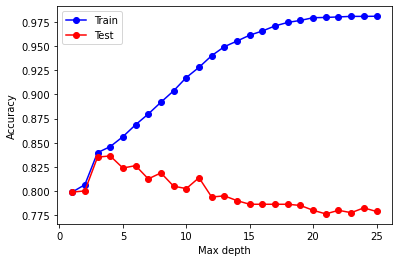

In [77]:
features = titanic_data_impute_train.columns
features_select = list(set(features) - set(['Survived']))
X = titanic_data_impute_train[features_select].values
y = titanic_data_impute_train['Survived'].values

result_train = []
result_test = []
max_depth = range(1,26)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

In [102]:
# tree
clf_tree = tree.DecisionTreeClassifier(criterion='entropy')
scores = cross_validate(clf_tree, X, y, cv=10, return_train_score=True)
print('Decision Tree\n Training accuracy: {:.2f}, Testing accuracy: {:.2f}'\
      .format(scores['train_score'].mean(), scores['test_score'].mean()))
clf_tree.fit(X, y)
tree_importance = clf_tree.feature_importances_

# SVM
clf_svm = svm.SVC(kernel='linear', C=1) 
scores = cross_validate(clf_svm, X, y, cv=10, return_train_score=True)
print('SVM\n Training accuracy: {:.2f}, Testing accuracy: {:.2f}'\
      .format(scores['train_score'].mean(), scores['test_score'].mean()))
clf_svm.fit(X, y)

Decision Tree
 Training accuracy: 0.93, Testing accuracy: 0.78
SVM
 Training accuracy: 0.79, Testing accuracy: 0.79


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

- Do any of your features have missing data? If so, which ones? What percent of observations have missing data?
    - Age, Cabin, and Embarked contain missing values.
    - 79.5% of observations have missing data
- What happens to observations with missing data when you run the decision tree and SVM models above?
    - It will arise an error. ValueError: "Input contains NaN, infinity or a value too large for dtype('float32')"
- Use one of the methods we discussed in class to impute missing values
    - I used the title of passengers' name to infer the age. See the 'data pre-processing' section.
- Rerun your decision tree and SVM on the new dataset with imputed missing values. What do you notice?
    - Using the new dataset with imputing missing values, the test accuracy for the max depth now has the convex pattern. The optimal depth is 3. Compared to the sex, the imputed feature 'age' might not be that important. The performance of SVM as seen in part 2.4 is not affected much from imputation.

## 3: Many Trees

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters. 
* What hyperparameters did you select with cross-validation?
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree and SVM?
* Create a plot that shows how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis).

In [1]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
result_train = []
result_test = []
max_depth = range(1,26)
for i in max_depth:
    clf = RandomForestClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
optimal_max_depth = max_depth[np.argmax(scores['test_score'])]

In [44]:
model = RandomForestClassifier(criterion='entropy',max_depth=optimal_max_depth)

get_accuracy(model, titanic_data_train, titanic_data_hold)
get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)

average training accuracy: 0.82
average testing accuracy: 0.80
hold-out accuracy: 0.81
average training accuracy: 0.83
average testing accuracy: 0.82
hold-out accuracy: 0.79


([0.8335436893203882, 0.8165123456790123, 0.7888888888888889],
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=4, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False))

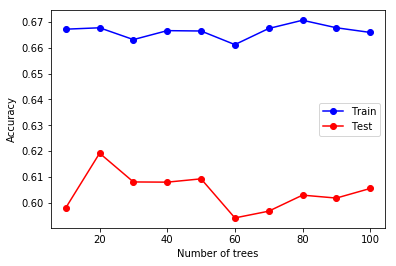

In [58]:
result_train = []
result_test = []
tree_num = range(10,101,10)
for i in tree_num:
    clf = RandomForestClassifier(n_estimators=i,criterion='entropy',max_depth=optimal_max_depth)
    scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 

plt.figure()
plt.plot(tree_num, result_train, '-o',color='blue',label='Train')
plt.plot(tree_num, result_test, '-o',color='red',label='Test')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()

* What hyperparameters did you select with cross-validation?
    - I chose the max depth as the hyperparameter.
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
    - The accuracy of the hold-out test data is similar to the cross-validated accuracy, which is what we expected.
* How does the RF performance compare to the decision tree and SVM?
    - RF is slightly better than the decision tree and SVM based on their accuracy.

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters. 
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)


In [46]:
from sklearn.ensemble import GradientBoostingClassifier

result_train = []
result_test = []
max_depth = range(1,26)
for i in max_depth:
    clf = GradientBoostingClassifier(max_depth=i)
    scores = cross_validate(clf, X, y, cv=10, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
optimal_max_depth = max_depth[np.argmax(scores['test_score'])]

In [47]:
model = GradientBoostingClassifier(max_depth=optimal_max_depth)
get_accuracy(model, titanic_data_train, titanic_data_hold)
get_accuracy(model, titanic_data_impute_train, titanic_data_impute_hold)

average training accuracy: 0.93
average testing accuracy: 0.81
hold-out accuracy: 0.83
average training accuracy: 0.98
average testing accuracy: 0.82
hold-out accuracy: 0.83


([0.9782217984281093, 0.8176543209876543, 0.8333333333333334],
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=6,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               n_iter_no_change=None, presort='auto', random_state=None,
               subsample=1.0, tol=0.0001, validation_fraction=0.1,
               verbose=0, warm_start=False))

In [68]:
model = GradientBoostingClassifier()
model.fit(X, y)
importances = model.feature_importances_

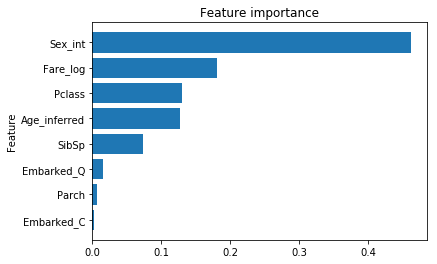

In [69]:
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features_select[i] for i in idx])
plt.ylabel("Feature")
plt.show()

The accuracy is slighted higher than previous models. In terms of the feature importance, sex, fare, Pclass and age are the top four features, similar to the result of 2.2

### 3.3 Feature Engineering
Revisit the features in your dataset.
* Are each of the features being appropriately included in the analysis? 
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Create a final table that summarizes the performance of your models as follows:

- Are each of the features being appropriately included in the analysis?
    - For age, I used the title of passengers' name to infer the age for those missing records.
    - For Cabin, because the proportion of missing value is very high (687/891), I directly removed this feature.
    - For Embarked, I filled the na with the model value and converted it to one hot encoder.
- Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
    - I used the title of passengers' name to infer the age for those missing records. See the section of 'data pre-processing'.

| Model | Cross-validated Performance   | Test Performance | 
|------|------|------|
|   Decision Tree        | 0.80 | 0.81 |
|   Decision Tree (with imputed missing values and new features)        | 0.77 | 0.78 |
|   SVM  | 0.79 | 0.79 |
|   SVM (with imputed missing values and new features)        | 0.78 | 0.80 |
|   Random Forest        | 0.80 | 0.81 |
|   Random Forest (with imputed missing values and new features)        | 0.82 | 0.79 |
|   Gradient Boosting    | 0.81 | 0.83 | 
|   Gradient Boosting (with imputed missing values and new features)        | 0.82 |  0.83 |


## 4: Neural Networks

###  Let's get familiar with neural networks!
Carry on the classification you did in parts 2.1 and 2.4 by using feed forward neural networks.
You are responsible for choosing the number of layers, their corresponding size, the activation functions and the choice of gradient descent algorithm (and its parameters e.g. learning rate). Pick those parameters by hand. For some of them you can also perform cross-validation if you wish. Your goal is to tune those parameters so that your test accuracy is higher than 83%. Make sure you process your data appropriately before training your networks.

* Report your accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

* No need to report anything here. It is a good exercise to experiment with different optimizers (gradient descent, stochastic gradient descent, AdaGrad etc), learning rates, batch sizes etc to get a feeling of how they affect neural network training.

In [106]:
import tensorflow as tf
import IPython
from sklearn.utils import shuffle
print("here")
data = titanic_data_impute_train
features = data.columns
X_train = titanic_data_impute_train[list(set(features) - set(['Survived']))].values
y_trainn = titanic_data_impute_train['Survived'].values


X_test = titanic_data_impute_hold [list(set(features) - set(['Survived']))].values
y_testt = titanic_data_impute_hold ['Survived'].values
y_trainn = np.expand_dims(y_trainn, 1)
y_testt = np.expand_dims(y_testt, 1)
y_train = enc.fit_transform(y_trainn)
y_test = enc.fit_transform(y_testt)
#IPython.embed()
mm, nn = X_train.shape
LR = 0.0001
batch_size = 100
display_step = 1
num_steps = int(np.floor(mm/ batch_size))
#IPython.embed()
# Network Parameters
n_hidden_1 = 10 # 1st layer number of neurons
n_hidden_2 = 10 # 2nd layer number of neurotest_t[45:44]ns
n_hidden_3 = 10
num_input = nn # Spiral data input 2-D points
num_classes = 2 # Total classes (red or black)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, 2])
## =================================================================
## =================================================================
## Initilaize Layer Weights
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
   # 'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'out': tf.Variable(tf.random_normal([n_hidden_3, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    #'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}
## =================================================================
## =================================================================
## Create model
def neural_net(x):
    # Hidden fully connected layer with 200 neurons
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 200 neurons
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer with a neuron for each class
    #layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['h3']), biases['b3']))
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    #IPython.embed()
    return out_layer

def neural_net_intermediate(x):
    # Hidden fully connected layer with 200 neurons
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
    # Hidden fully connected layer with 200 neurons
    layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return layer_1, layer_2#tf.matmul(layer_1, weights['h2'])
## =================================================================
## =================================================================
## Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=LR)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))# cast to new data type

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
## =================================================================
## =================================================================
## Start training
sess=tf.Session()
# Run the initializer
sess.run(init)
for kk in range(1,5000):
    for step in range(1, num_steps+1):## check num_steps batch_sixe !!!!!!!
        X_trainn, y_trainn = shuffle(X_train, y_train)
        batch_x, batch_y = X_trainn[(batch_size)*(step-1)+1:batch_size*(step), ], y_trainn[(batch_size)*(step-1)+1:batch_size*(step),]  #mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        #IPython.embed()

        #print('Here')
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y.toarray()})

    if kk%50 == 0:
        #loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train.toarray()})
        #print("Epoch " + str(kk) + ", Training Loss= " + "{:.4f}".format(loss))
        acc_train = sess.run(correct_pred, feed_dict={X: X_train, Y: y_train.toarray()})
        print(" Train Accuracy=" + str(np.sum(acc_train)/len(acc_train)))
        acc_test = sess.run(correct_pred, feed_dict={X: X_test, Y: y_test.toarray()})
        print(" Test Accuracy=" + str(np.sum(acc_test)/len(acc_test)))

here
 Train Accuracy=0.3651685393258427
 Test Accuracy=0.3463687150837989
 Train Accuracy=0.574438202247191
 Test Accuracy=0.5586592178770949
 Train Accuracy=0.5575842696629213
 Test Accuracy=0.5363128491620112
 Train Accuracy=0.5646067415730337
 Test Accuracy=0.547486033519553
 Train Accuracy=0.5730337078651685
 Test Accuracy=0.553072625698324
 Train Accuracy=0.5814606741573034
 Test Accuracy=0.5810055865921788
 Train Accuracy=0.5926966292134831
 Test Accuracy=0.6033519553072626
 Train Accuracy=0.6039325842696629
 Test Accuracy=0.6145251396648045
 Train Accuracy=0.6053370786516854
 Test Accuracy=0.6145251396648045
 Train Accuracy=0.6474719101123596
 Test Accuracy=0.6703910614525139
 Train Accuracy=0.6685393258426966
 Test Accuracy=0.6703910614525139
 Train Accuracy=0.6811797752808989
 Test Accuracy=0.6815642458100558
 Train Accuracy=0.702247191011236
 Test Accuracy=0.6871508379888268
 Train Accuracy=0.726123595505618
 Test Accuracy=0.7094972067039106
 Train Accuracy=0.7289325842696629

* Report your accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

After experimenting a bit we ended up using a learning rate of 0.0001 with batch size 10. We also used 3 hidden layers of dimension 10 each. The activation function chosen was the ReLU. With this architecture we could easily achieve an accuracy higher than 78%. Some important takeaways: 

1) Large hidden layers (or too many of them) will lead to overfitting (will need regularization). Given our dataset size we cannot choose a very large number of parameters (weights and biases) for our network.

2) You choose the number of epochs according to your train-test accuracies that you print as the training goes on. More specifically, once you see your testing accuracy drop while training accuracy is still improving, this is a good sign to stop training as you will most likely be overfitting after that point. 

3) As far as the optimization algorithm is concerned, adaptive methods like Adam seem to be preferred in neural network training but this is an open debate.

4) It is typical to use a a stochastic version of optimization with diminishing learning rate in neural network training. The stochastic part is important as usually the amount of data is large and doing backpropagation using the whole dataset at each iteration can be very computationally intensive.
